## *NEWSGROUPS CLASSIFICATION PROJECT*

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import re
import string

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import pandas as pd
import random

In [ ]:
# Loading data
from sklearn.datasets import fetch_20newsgroups

mydata = fetch_20newsgroups(subset='all', shuffle=True, remove = ('headers', 'footers', 'quotes'))

#Data Analysis

In [ ]:
list(mydata)

['data', 'filenames', 'target_names', 'target', 'DESCR']

In [ ]:
print('Data size:', len(mydata['data']))

Data size: 18846


In [ ]:
# List all categories
mydata['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [ ]:
# Number of occurrences of each category
targets, frequency = np.unique(mydata['target'], return_counts=True)
targets, frequency

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([799, 973, 985, 982, 963, 988, 975, 990, 996, 994, 999, 991, 984,
        990, 987, 997, 910, 940, 775, 628]))

In [ ]:
targets_str = np.array(mydata['target_names'])
print(list(zip(targets_str, frequency)))

[('alt.atheism', 799), ('comp.graphics', 973), ('comp.os.ms-windows.misc', 985), ('comp.sys.ibm.pc.hardware', 982), ('comp.sys.mac.hardware', 963), ('comp.windows.x', 988), ('misc.forsale', 975), ('rec.autos', 990), ('rec.motorcycles', 996), ('rec.sport.baseball', 994), ('rec.sport.hockey', 999), ('sci.crypt', 991), ('sci.electronics', 984), ('sci.med', 990), ('sci.space', 987), ('soc.religion.christian', 997), ('talk.politics.guns', 910), ('talk.politics.mideast', 940), ('talk.politics.misc', 775), ('talk.religion.misc', 628)]


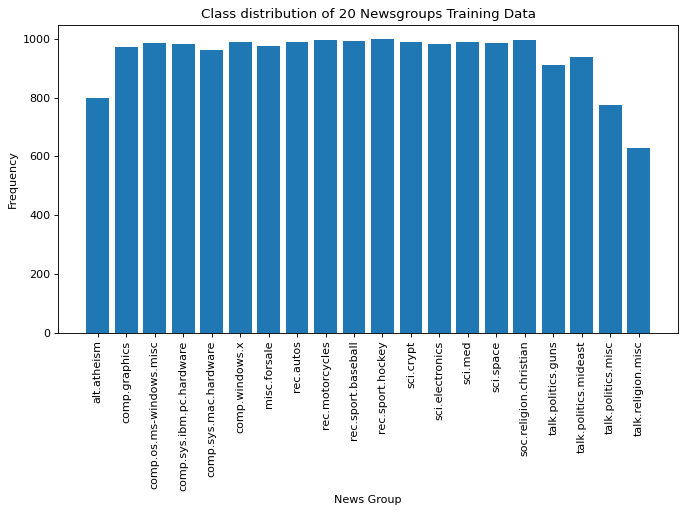

In [ ]:
# Distribution of data classes
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets_str,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

We see that all categories have a decent number of samples and don't have much imbalance.



In [ ]:
# Convert to dataFrame
df = pd.DataFrame(data=mydata['data'], columns=['data'])
df['target'] = mydata['target']

target_names = mydata['target_names']
df['target'] = df['target'].apply(lambda x: target_names[x])

In [ ]:
df.head()

,data,target
0,\n\nI am sure some bashers of Pens fans are pr...,rec.sport.hockey
1,My brother is in the market for a high-perform...,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,comp.sys.mac.hardware


In [ ]:
# Detailed information about columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18846 entries, 0 to 18845
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   data    18846 non-null  object
 1   target  18846 non-null  object
 2   length  18846 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 441.8+ KB


In [ ]:
# Shows the dataset based on the article text length and displays the first 15 lines
df['length'] = df['data'].apply(len)
df.head(15)

,data,target,length
0,\n\nI am sure some bashers of Pens fans are pr...,rec.sport.hockey,712
1,My brother is in the market for a high-perform...,comp.sys.ibm.pc.hardware,324
2,\n\n\n\n\tFinally you said what you dream abou...,talk.politics.mideast,1678
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,comp.sys.ibm.pc.hardware,781
4,1) I have an old Jasmine drive which I cann...,comp.sys.mac.hardware,666
5,\n\nBack in high school I worked as a lab assi...,sci.electronics,387
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,comp.sys.mac.hardware,134
7,"\n[stuff deleted]\n\nOk, here's the solution t...",rec.sport.hockey,780
8,"\n\n\nYeah, it's the second one. And I believ...",rec.sport.hockey,311
9,\nIf a Christian means someone who believes in...,talk.religion.misc,417


In [ ]:
# length of the longest article in the dataset
df['length'].max()

158791

In [ ]:
# value of the "target" column for the rows in which the article length is the longest
print(df[df['length'] == df['length'].max()]['target'])

15076    comp.os.ms-windows.misc
Name: target, dtype: object


#Data preparation

We will perform preparatory steps such as Tokenization, converting everything to lowercase, removing stopwords, lemmatization and converting text data to vector representation

In [ ]:
# Division of data into training and testing
X_train, X_test, y_train, y_test = train_test_split(mydata['data'], mydata['target'], test_size=0.2, random_state=42)

print('Training data size:', len(X_train))
print('Testing data size:', len(X_test))

Training data size: 15076
Testing data size: 3770


In [ ]:
mydata_train_df = pd.DataFrame({'data': X_train, 'target': y_train})
mydata_train_df.head()

,data,target
0,Has anyone tried connecting an Apple Laserwrit...,3
1,COMET (Commercial Experiment Transport) is to ...,14
2,\n:It occurs to me that if they get a wiretap ...,11
3,\nNot to mention that the story was rewritten ...,16
4,\nBut the NSA will not be doing any wiretappin...,11


In [ ]:
# Text pre-processing stages - will remove numbers, capital letters and punctuation - traning data
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

mydata_train_df['data'] = mydata_train_df.data.map(alphanumeric).map(punc_lower)
mydata_train_df.head()

,data,target
0,has anyone tried connecting an apple laserwrit...,3
1,comet commercial experiment transport is to ...,14
2,\n it occurs to me that if they get a wiretap ...,11
3,\nnot to mention that the story was rewritten ...,16
4,\nbut the nsa will not be doing any wiretappin...,11


In [ ]:
mydata_test_df = pd.DataFrame({'data': X_test, 'target': y_test})
mydata_test_df.head()

,data,target
0,\n\n\n\n\nI don't remember the article that yo...,18
1,,8
2,Archive-Name: rec-autos/part2\n\nAutomotive Ma...,7
3,\n\nThe Japanese are still on the learning cur...,14
4,"[..stuff deleted]\nOh, but can Big Brother aff...",11


In [ ]:
# Text preprocessing steps - will remove numbers, capital letters and punctuation - test data
alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

mydata_test_df['data'] = mydata_test_df.data.map(alphanumeric).map(punc_lower)
mydata_test_df.head()

,data,target
0,\n\n\n\n\ni don t remember the article that yo...,18
1,,8
2,archive name rec autos \n\nautomotive mailin...,7
3,\n\nthe japanese are still on the learning cur...,14
4,stuff deleted \noh but can big brother aff...,11


In [ ]:
# Bag of Words - counting how many times a given word appears in the document, allowing you to create a numerical representation of the text
count_vect = CountVectorizer(stop_words='english') # English "stop words" (frequently occurring words like "the", "is", "and", etc.) will be ignored

# first recognizes all unique words in the data, and then 'transforms' the data, turning the text into numerical vectors,
# where each number represents how many times the word appears in the document
X_train_cv = count_vect.fit_transform(mydata_train_df.data)  # learns vocabulary coding and one-hot encoding
X_test_cv = count_vect.transform(mydata_test_df.data)

print(X_train_cv.shape)
print(type(X_train_cv))

(6400, 48284)
<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
X_train_cv_df = pd.DataFrame(X_train_cv.todense()) # conversion to a dense matrix and creates a data frame
X_train_cv_df.columns = sorted(count_vect.vocabulary_) # the dictionary contains all unique words as keys and their corresponding indexes as values
X_train_cv_df.head()

,aa,aaa,aaaaa,aaaaarrrrgh,aaaall,aachen,aaf,aagain,aalac,aam,...,zye,zygon,zyt,zyu,zyv,zyxel,zz,zzd,zznp,zzrk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test_cv_df = pd.DataFrame(X_test_cv.todense())
X_test_cv_df.columns = sorted(count_vect.vocabulary_)
X_test_cv_df.head()

,aa,aaa,aaaaa,aaaaarrrrgh,aaaall,aachen,aaf,aagain,aalac,aam,...,zye,zygon,zyt,zyu,zyv,zyxel,zz,zzd,zznp,zzrk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# TF-IDF - used to assign a weight to each word in a document based on its frequency of occurrence in a given document in relation to the entire set of documents
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cv_df) #X_train_counts
X_train_tfidf.shape

(6400, 48284)

In [ ]:
# Creating a document matrix using TF-IDF
tfidfV = TfidfVectorizer(stop_words='english')

# X_train_tfidfV - matrix where rows represent documents and columns represent unique words
X_train_tfidfV = tfidfV.fit_transform(mydata_train_df.data) # fit_transform learns the vocab and one-hot encodes
# uses a dictionary "trained" on training data to transform test data into the same numerical form
X_test_tfidfV = tfidfV.transform(mydata_test_df.data) # transform uses the same vocab and one-hot encodes

print(type(X_train_tfidfV))

(6400, 48284)
<class 'scipy.sparse._csr.csr_matrix'>


In [ ]:
X_train_tfidfV_df = pd.DataFrame(X_train_tfidfV.todense())
X_train_tfidfV_df.columns = sorted(tfidfV.vocabulary_)
X_train_tfidfV_df.head()

,aa,aaa,aaaaa,aaaaarrrrgh,aaaall,aachen,aaf,aagain,aalac,aam,...,zye,zygon,zyt,zyu,zyv,zyxel,zz,zzd,zznp,zzrk
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Lemmatization (note that other processing such as alphanumeric and lowercase removal has already been done)
w_tokenizer = nltk.tokenize.WhitespaceTokenizer() # divides text into units (tokens) based on whitespace (e.g. spaces, tabs, newlines)
lemmatizer = nltk.stem.WordNetLemmatizer() # transforms words into their base form (e.g. "running" becomes "running")

# text as input, splits it into tokens using a tokenizer, lemmatizes each token and concatenates them back into one string
def lemmatize_text(text):
    return(" ".join([lemmatizer.lemmatize(w,"v") for w in w_tokenizer.tokenize(text)]))

# we create a new column "data lemmatized" using the lemmatize text function
mydata_train_df["data_lemmatized"] = mydata_train_df.data.apply(lemmatize_text)
mydata_test_df["data_lemmatized"] = mydata_test_df.data.apply(lemmatize_text)

# Using Tfidf removes words that appear in less than 0.05 percent of documents
# min_df which ignores words that appear in less than 0.05% of documents (a way to reduce data dimensions by removing the least frequent words)
tfidfV = TfidfVectorizer(stop_words='english', min_df = 0.0005)

#Data for neural networks
xTrain = tfidfV.fit_transform(mydata_train_df.data_lemmatized)
yTrainHot = to_categorical(mydata_train_df["target"], num_classes=20)
xTest = tfidfV.transform(mydata_test_df.data_lemmatized)
yTestHot = to_categorical(mydata_test_df["target"], num_classes=20)


# New shape of the neural network. Reduces dimensions to 13946 to keep only important words and speed up the learning process
print(xTrain.shape)

# Reference model

In [ ]:
# Division of data into training and validation data (20 by 80)
xTrain, xVal, yTrainHot, yValHot = train_test_split(xTrain, yTrainHot, test_size=0.2, random_state=42)

In [ ]:
# We build a neural network model
# (baseline - input layer and one hidden layer of 32 neurons each and output layer of 20)
model1 = Sequential()
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(20, activation='softmax'))

# We compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model1.fit(xTrain.toarray(), yTrainHot, epochs=20, batch_size=200, validation_data=(xVal.toarray(), yValHot))
# Accuracy refers to the percentage of correct predictions made by the model, while loss is a measure of the model's prediction error
# (i.e. how far the predictions are from the actual values).

Epoch 1/20
26/26 [==============================] - 7s 32ms/step - loss: 2.9792 - accuracy: 0.0885 - val_loss: 2.9470 - val_accuracy: 0.1219
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 2.8736 - accuracy: 0.1842 - val_loss: 2.8263 - val_accuracy: 0.2047
Epoch 3/20
26/26 [==============================] - 0s 9ms/step - loss: 2.6671 - accuracy: 0.3324 - val_loss: 2.6223 - val_accuracy: 0.3156
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 2.3549 - accuracy: 0.5193 - val_loss: 2.3467 - val_accuracy: 0.4812
Epoch 5/20
26/26 [==============================] - 0s 9ms/step - loss: 1.9789 - accuracy: 0.6770 - val_loss: 2.0456 - val_accuracy: 0.5828
Epoch 6/20
26/26 [==============================] - 0s 9ms/step - loss: 1.5969 - accuracy: 0.7949 - val_loss: 1.7715 - val_accuracy: 0.6336
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 1.2656 - accuracy: 0.8490 - val_loss: 1.5549 - val_accuracy: 0.6500
Epoch 8/20
26/26 

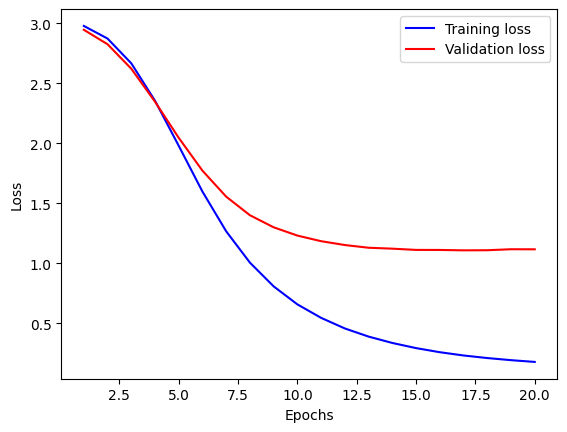

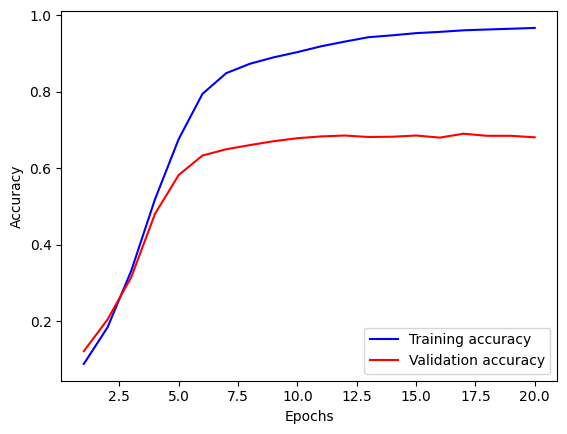

In [ ]:
# Learning history analysis
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#We add regularizations
We will add early stopping to the reference model

In [ ]:
# Tuning hyperparameters - number of epochs and number of neurons
# change the width of layer - 1 and 2 from 32 to 16, number of epochs 30
# application of regularization - early stopping
# We build a neural network model
model1 = Sequential()
model1.add(Dense(32, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(20, activation='softmax'))

# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model1.fit(xTrain.toarray(), yTrainHot, epochs=20, batch_size=200, validation_data=(xVal.toarray(), yValHot), callbacks=[EarlyStopping(patience=3)])

Epoch 1/20
26/26 [==============================] - 2s 20ms/step - loss: 2.9830 - accuracy: 0.0852 - val_loss: 2.9574 - val_accuracy: 0.1008
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 2.8921 - accuracy: 0.2422 - val_loss: 2.8459 - val_accuracy: 0.2469
Epoch 3/20
26/26 [==============================] - 0s 11ms/step - loss: 2.6947 - accuracy: 0.3971 - val_loss: 2.6416 - val_accuracy: 0.3500
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 2.3786 - accuracy: 0.5545 - val_loss: 2.3498 - val_accuracy: 0.4672
Epoch 5/20
26/26 [==============================] - 0s 9ms/step - loss: 1.9825 - accuracy: 0.7031 - val_loss: 2.0335 - val_accuracy: 0.5734
Epoch 6/20
26/26 [==============================] - 0s 10ms/step - loss: 1.5929 - accuracy: 0.7895 - val_loss: 1.7597 - val_accuracy: 0.6523
Epoch 7/20
26/26 [==============================] - 0s 10ms/step - loss: 1.2629 - accuracy: 0.8316 - val_loss: 1.5492 - val_accuracy: 0.6695
Epoch 8/20
26/

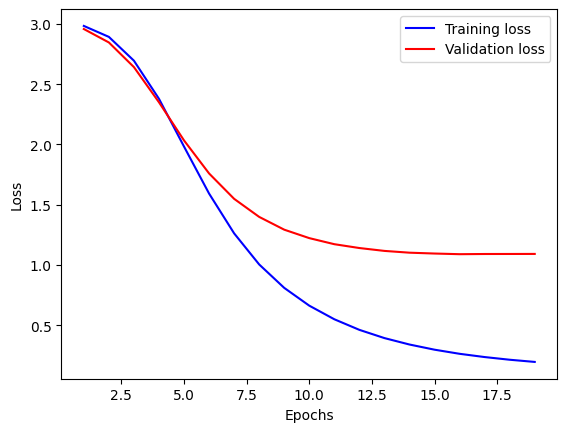

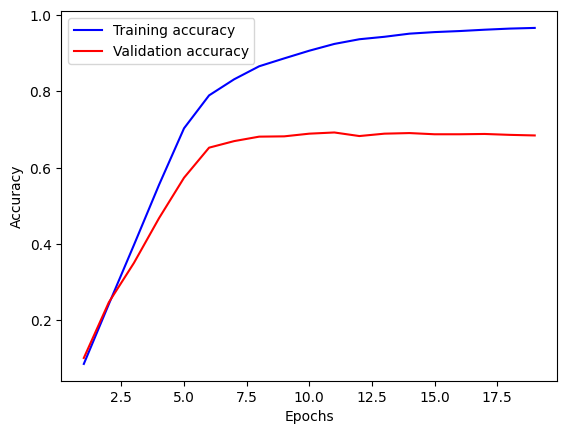

In [ ]:
# Learning history analysis
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Results: val_accuracy 0.6844, slightly better than the bias model

#Tuning hyperparameters

In [ ]:
# Tuning hyperparameters
# change layer width - 1 from 32 to 64,
# We build a neural network model
model2 = Sequential()
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(20, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model2.fit(xTrain.toarray(), yTrainHot, epochs=20, batch_size=200, validation_data=(xVal.toarray(), yValHot), callbacks=[EarlyStopping(patience=3)])

Epoch 1/20
26/26 [==============================] - 2s 27ms/step - loss: 2.9758 - accuracy: 0.1428 - val_loss: 2.9362 - val_accuracy: 0.2523
Epoch 2/20
26/26 [==============================] - 1s 20ms/step - loss: 2.8355 - accuracy: 0.3232 - val_loss: 2.7795 - val_accuracy: 0.2977
Epoch 3/20
26/26 [==============================] - 1s 23ms/step - loss: 2.5653 - accuracy: 0.4061 - val_loss: 2.5307 - val_accuracy: 0.3523
Epoch 4/20
26/26 [==============================] - 1s 23ms/step - loss: 2.1810 - accuracy: 0.5201 - val_loss: 2.2070 - val_accuracy: 0.4523
Epoch 5/20
26/26 [==============================] - 1s 26ms/step - loss: 1.7289 - accuracy: 0.6906 - val_loss: 1.8587 - val_accuracy: 0.5859
Epoch 6/20
26/26 [==============================] - 1s 23ms/step - loss: 1.2896 - accuracy: 0.8299 - val_loss: 1.5636 - val_accuracy: 0.6570
Epoch 7/20
26/26 [==============================] - 0s 10ms/step - loss: 0.9441 - accuracy: 0.8822 - val_loss: 1.3722 - val_accuracy: 0.6750
Epoch 8/20
26

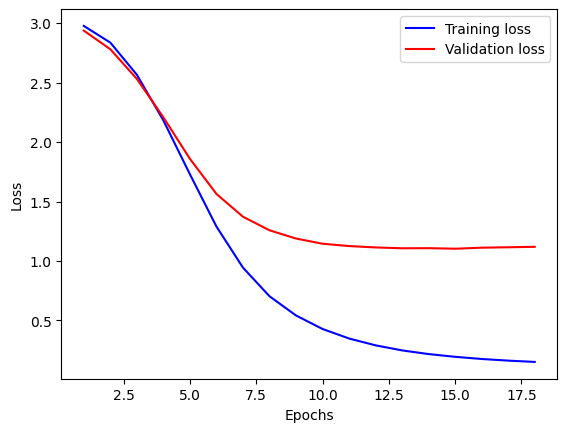

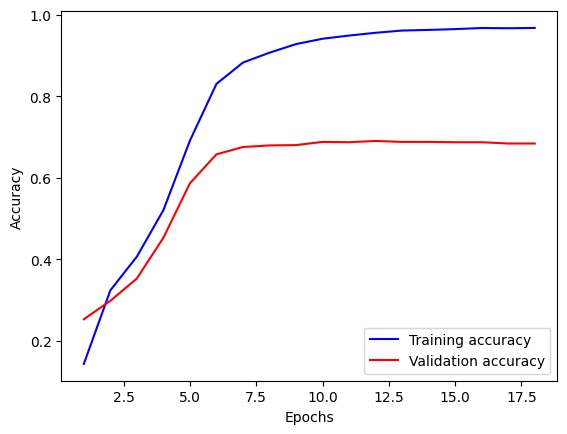

In [ ]:
# Learning history analysis
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Hyperparameter tuning
# build a neural network model
model3 = Sequential()
model3.add(Dense(16,activation = 'relu'))
model3.add(Dense(64,activation = 'relu'))
model3.add(Dense(20, activation='softmax'))

# compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model3.fit(xTrain.toarray(), yTrainHot, epochs=20, batch_size=200, validation_data=(xVal.toarray(), yValHot), callbacks=[EarlyStopping(patience=3)])

Epoch 1/20
26/26 [==============================] - 2s 21ms/step - loss: 2.9894 - accuracy: 0.1014 - val_loss: 2.9738 - val_accuracy: 0.1906
Epoch 2/20
26/26 [==============================] - 0s 10ms/step - loss: 2.9323 - accuracy: 0.2506 - val_loss: 2.8937 - val_accuracy: 0.2453
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 2.7861 - accuracy: 0.3135 - val_loss: 2.7233 - val_accuracy: 0.2953
Epoch 4/20
26/26 [==============================] - 0s 10ms/step - loss: 2.5255 - accuracy: 0.4352 - val_loss: 2.4756 - val_accuracy: 0.3883
Epoch 5/20
26/26 [==============================] - 0s 11ms/step - loss: 2.1932 - accuracy: 0.5666 - val_loss: 2.2067 - val_accuracy: 0.4898
Epoch 6/20
26/26 [==============================] - 0s 11ms/step - loss: 1.8402 - accuracy: 0.6998 - val_loss: 1.9429 - val_accuracy: 0.5961
Epoch 7/20
26/26 [==============================] - 0s 9ms/step - loss: 1.5005 - accuracy: 0.7807 - val_loss: 1.7134 - val_accuracy: 0.6250
Epoch 8/20
26/

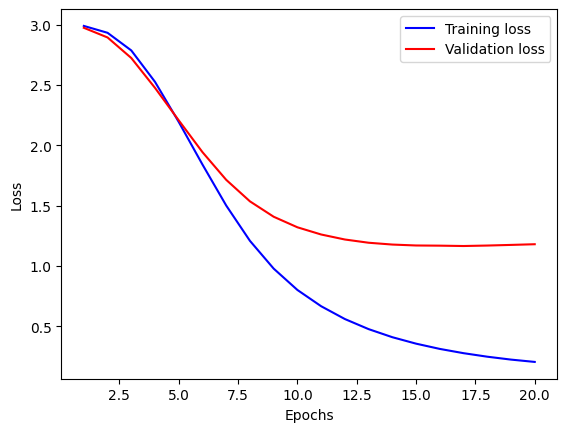

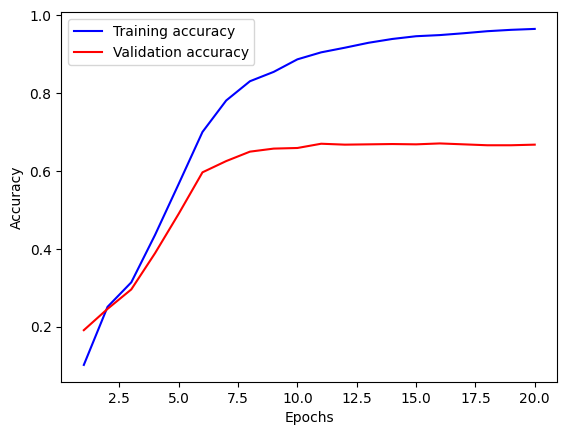

In [ ]:
# Learning history analysis
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Tuning hyperparameters
# We build a neural network model
model4 = Sequential()
model4.add(Dense(32,activation = 'relu'))
model4.add(Dense(64,activation = 'relu'))
model4.add(Dense(20, activation='softmax'))

# compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model4.fit(xTrain.toarray(), yTrainHot, epochs=10, batch_size=200, validation_data=(xVal.toarray(), yValHot), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
26/26 [==============================] - 2s 20ms/step - loss: 2.9830 - accuracy: 0.1484 - val_loss: 2.9536 - val_accuracy: 0.2461
Epoch 2/10
26/26 [==============================] - 0s 9ms/step - loss: 2.8739 - accuracy: 0.3721 - val_loss: 2.8047 - val_accuracy: 0.3992
Epoch 3/10
26/26 [==============================] - 0s 10ms/step - loss: 2.6019 - accuracy: 0.5639 - val_loss: 2.5045 - val_accuracy: 0.4875
Epoch 4/10
26/26 [==============================] - 0s 10ms/step - loss: 2.1408 - accuracy: 0.7086 - val_loss: 2.0780 - val_accuracy: 0.6164
Epoch 5/10
26/26 [==============================] - 0s 9ms/step - loss: 1.6091 - accuracy: 0.8102 - val_loss: 1.6891 - val_accuracy: 0.6570
Epoch 6/10
26/26 [==============================] - 0s 10ms/step - loss: 1.1741 - accuracy: 0.8521 - val_loss: 1.4268 - val_accuracy: 0.6758
Epoch 7/10
26/26 [==============================] - 0s 12ms/step - loss: 0.8726 - accuracy: 0.8779 - val_loss: 1.2709 - val_accuracy: 0.6781
Epoch 8/10
26/2

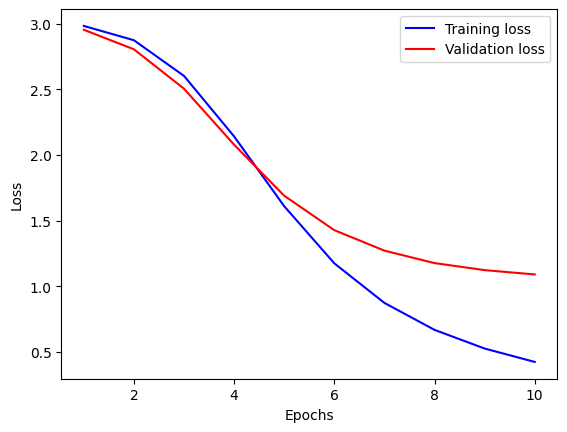

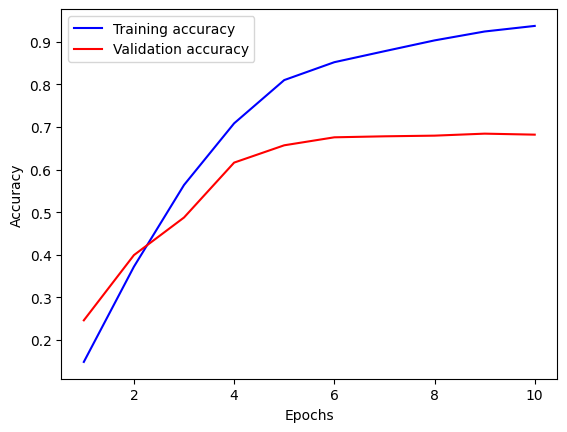

In [ ]:
# Learning history analysis
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Tuning hyperparameters
# We build a neural network model
model5 = Sequential()
model5.add(Dense(16,activation = 'relu'))
model5.add(Dense(16,activation = 'relu'))
model5.add(Dense(20, activation='softmax'))

# compile the model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model5.fit(xTrain.toarray(), yTrainHot, epochs=10, batch_size=200, validation_data=(xVal.toarray(), yValHot), callbacks=[EarlyStopping(patience=3)])

Epoch 1/10
26/26 [==============================] - 2s 20ms/step - loss: 2.9884 - accuracy: 0.0721 - val_loss: 2.9737 - val_accuracy: 0.0812
Epoch 2/10
26/26 [==============================] - 0s 12ms/step - loss: 2.9406 - accuracy: 0.1068 - val_loss: 2.9162 - val_accuracy: 0.1375
Epoch 3/10
26/26 [==============================] - 0s 15ms/step - loss: 2.8450 - accuracy: 0.2010 - val_loss: 2.8177 - val_accuracy: 0.2164
Epoch 4/10
26/26 [==============================] - 0s 13ms/step - loss: 2.6981 - accuracy: 0.2965 - val_loss: 2.6810 - val_accuracy: 0.2703
Epoch 5/10
26/26 [==============================] - 0s 13ms/step - loss: 2.5036 - accuracy: 0.4082 - val_loss: 2.5132 - val_accuracy: 0.3328
Epoch 6/10
26/26 [==============================] - 0s 14ms/step - loss: 2.2743 - accuracy: 0.4838 - val_loss: 2.3212 - val_accuracy: 0.3898
Epoch 7/10
26/26 [==============================] - 0s 13ms/step - loss: 2.0272 - accuracy: 0.5623 - val_loss: 2.1293 - val_accuracy: 0.4617
Epoch 8/10
26

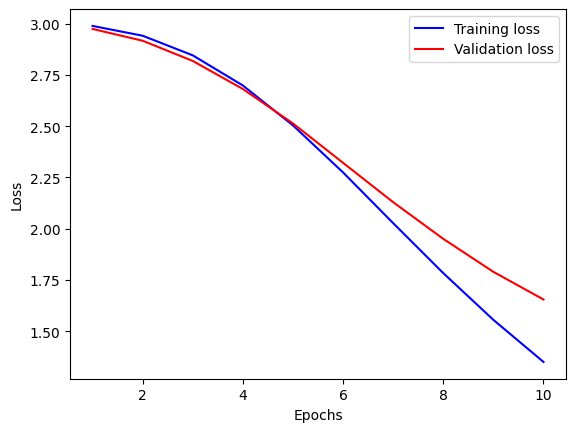

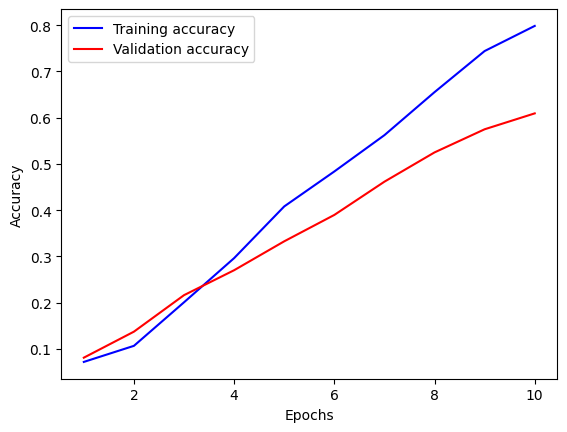

In [ ]:
# Learning history analysis
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Logistic regression
Comparison of the network with a classic classifier - logistic regression.

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lgr = LogisticRegression()

y_train_labels = np.argmax(yTrainHot, axis=1)
y_test_labels = np.argmax(yTestHot, axis=1)

lgr.fit(xTrain.toarray(), y_train_labels)
predicted_labels = lgr.predict(xTest.toarray())

accuracy_of_model = accuracy_score(y_test_labels, predicted_labels)

print("Accuracy is", accuracy_of_model)

Accuracy is 0.686875


Conclusions: accurancy very similar, even slightly better than neural networks

# SUMMARY

During the experiments performed, it was not possible to improve the accuracy of the reference model. Additionally, it turned out that the classic logistic regression classifier had a better accuracy of 0.686875 than the reference model, which had an accuracy of 0.6844. Below is an evaluation of the best neural network model on test data, its accuracy and loss.

In [ ]:
# Evaluate the best model on test data
scores = model1.evaluate(xTest.toarray(), yTestHot, verbose=0)
test_loss, test_accuracy = model1.evaluate(xTest.toarray(), yTestHot)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

50/50 [==============================] - 0s 3ms/step - loss: 1.1470 - accuracy: 0.6769
Test loss: 1.146955132484436
Test accuracy: 0.6768749952316284


In [ ]:
from sklearn.metrics import classification_report

# Predicting labels on test data
y_pred = model3.predict(xTest.toarray())

# Converting predictions into labels
y_pred_labels = np.argmax(y_pred, axis = 1)

# Converting real labels from one-hot to one-dimensional format
y_true_labels = np.argmax(yTestHot, axis=1)

# Create a classification report
classification_report = classification_report(y_true_labels, y_pred_labels, target_names = mydata['target_names'])

print(classification_report)

50/50 [==============================] - 0s 2ms/step
                          precision    recall  f1-score   support

             alt.atheism       0.45      0.54      0.49        67
           comp.graphics       0.53      0.55      0.54        71
 comp.os.ms-windows.misc       0.62      0.44      0.51        89
comp.sys.ibm.pc.hardware       0.55      0.55      0.55        84
   comp.sys.mac.hardware       0.62      0.60      0.61        65
          comp.windows.x       0.78      0.80      0.79        83
            misc.forsale       0.73      0.67      0.70        92
               rec.autos       0.79      0.61      0.69       100
         rec.motorcycles       0.49      0.75      0.59        96
      rec.sport.baseball       0.72      0.93      0.81        71
        rec.sport.hockey       0.94      0.84      0.88        91
               sci.crypt       0.91      0.78      0.84        88
         sci.electronics       0.61      0.70      0.65        86
                 sci.m